In [1]:
%reset
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


- open original files (note: need to open with `decode_times=False`, python hates climate style dates)

In [2]:
tdir = '/gpfs/home/hnb15vcu/scratch/TOM12_3branch_Files/'

obs_file = xr.open_dataset(f'{tdir}/Fluxes_Observations_umol-m2-s_umol-L.nc', decode_times=False)
gcb_file = xr.open_dataset(f'{tdir}/Fluxes_Models_GCB_umol-m2-s_umol-L.nc', decode_times=False)
eco_file = xr.open_dataset(f'{tdir}/Fluxes_Models_ECO_umol-m2-s_umol-L.nc', decode_times=False)
mor_file = xr.open_dataset(f'{tdir}/Fluxes_Models_MOR_umol-m2-s_umol-L.nc', decode_times=False)



- for each thing make a holding dataset that will hold just the depth profiles we want
- put depths from original dataset into the depth profile arrays
- get list of variables in the original datasets


In [5]:
mor_dp = xr.Dataset(
    {var: (["DEPTH"], np.zeros(33)) for var in mor_file.data_vars}
)
obs_dp = xr.Dataset(
    {var: (["DEPTH"], np.zeros(33)) for var in mor_file.data_vars}
)
gcb_dp = xr.Dataset(
    {var: (["DEPTH"], np.zeros(33)) for var in mor_file.data_vars}
)
eco_dp = xr.Dataset(
    {var: (["DEPTH"], np.zeros(33)) for var in mor_file.data_vars}
)

mor_dp['DEPTH'] = obs_file['DEPTH']
obs_dp['DEPTH'] = obs_file['DEPTH']
gcb_dp['DEPTH'] = obs_file['DEPTH']
eco_dp['DEPTH'] = obs_file['DEPTH']


print(list(mor_file.data_vars))

['DEPTH_bnds', 'EXP', 'CAC', 'SIL', 'DOC', 'POC', 'GOC', 'HOC']


## code to loop thru each var in each dataset, get median, and save

note that I did it in 2 steps, 0-2 and 2-end, because it's having memory problems which is absolutely unreasonable. hence `for x in range(2,len(dss))`

In [6]:
run = False
if run:
    dss = [obs_file, gcb_file, eco_file, mor_file]
    dps = [obs_dp, gcb_dp, eco_dp, mor_dp]
    names = ['OBS','GCB','ECO','MOR']
    tvars = ['EXP', 'CAC', 'SIL', 'DOC', 'POC', 'GOC', 'HOC']


    for x in range(2,len(dss)): #did it in 2 steps, 0-2 and 2-end, because it's having memory problems 

        tds = dss[x] #get original dataset
        tdp = dps[x] #retreive dp dataset that you want to put yr files into
        tnam = names[x] #name of dataset

        for tvar in tvars:
            try:
                tdat = tds[tvar].values
                print(f'{tnam} {tvar}')

                dumdp = np.zeros(33)

                for i in range(0,33): 
                    if ((tnam == 'OBS') & (tvar == 'DOC')): #obs ds has different size doc
                        tlev = tdat[i,:,:]
                    else:
                        tlev = tdat[:,i,:,:] #get out all available data in level
                    non_nan_values = tlev[~np.isnan(tlev)] #get non nans

                    if len(non_nan_values) == 0: #if no obs, set level to nan

                        dumdp[i] = np.nan
                    else:
                        dumdp[i] = np.median(non_nan_values) #get median
                tdp[tvar].values = dumdp #put into new ds
            except:
                print(f'{tnam} {tvar} saving issue - does the variable exist?')

        print(f'saving ds here: /data/median_dp_umol-m2-s_umol-L_{tnam}.nc')
        tdp.to_netcdf(f'./data/median_dp_umol-m2-s_umol-L_{tnam}.nc')
              

ECO EXP
ECO CAC
ECO SIL
ECO DOC
ECO POC
ECO GOC
ECO HOC saving issue - does the variable exist?
saving ds here: /data/median_dp_umol-m2-s_umol-L_ECO.nc
MOR EXP
MOR CAC
MOR SIL
MOR DOC
MOR POC
MOR GOC
MOR HOC
saving ds here: /data/median_dp_umol-m2-s_umol-L_MOR.nc


## quick spot-check 

In [14]:
tlev = eco_file.CAC[:,20,:,:].values
non_nan_values = tlev[~np.isnan(tlev)]
print(np.median(non_nan_values))

print(eco_dp.CAC[20].values)

0.003411331689351371
0.003411331689351371


## reopen plot the resulting depth profile datasets

In [22]:
-tdp['DEPTH'].values

array([   -0.,   -10.,   -20.,   -30.,   -50.,   -75.,  -100.,  -125.,
        -150.,  -200.,  -250.,  -300.,  -400.,  -500.,  -600.,  -700.,
        -800.,  -900., -1000., -1100., -1200., -1300., -1400., -1500.,
       -1750., -2000., -2500., -3000., -3500., -4000., -4500., -5000.,
       -5500.], dtype=float32)

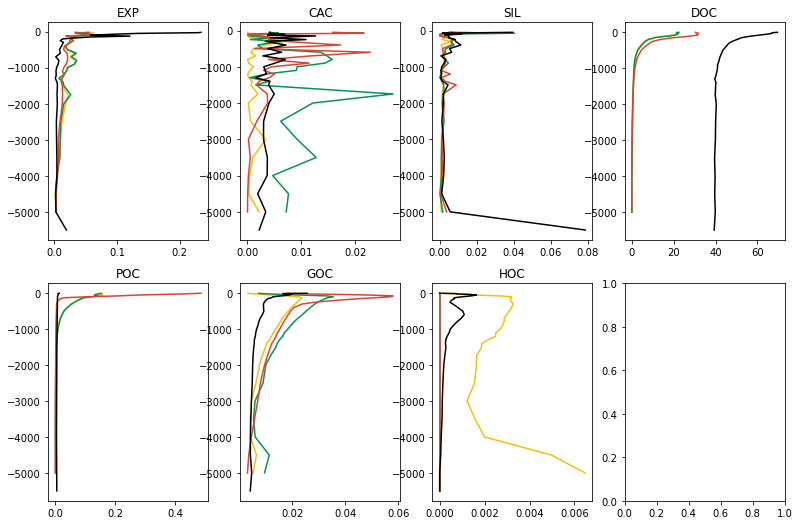

In [24]:
mor_dp = xr.open_dataset('./data/median_dp_umol-m2-s_umol-L_MOR.nc')
eco_dp = xr.open_dataset('./data/median_dp_umol-m2-s_umol-L_ECO.nc')
gcb_dp = xr.open_dataset('./data/median_dp_umol-m2-s_umol-L_GCB.nc')
obs_dp = xr.open_dataset('./data/median_dp_umol-m2-s_umol-L_OBS.nc')

dps = [mor_dp, eco_dp, gcb_dp, obs_dp]
labs = ['MOR', 'ECO', 'GCB', 'OBS']

colors_dict = {
        'OBS':  'k',
        'ECO': '#02954f',
        'GCB': '#de4231', 
        'MOR': '#f3c108',
    }



fact = 1.1
fig, axs = plt.subplots(2,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvars = ['EXP', 'CAC', 'SIL', 'DOC', 'POC', 'GOC', 'HOC'] 
for i in range(0,len(tvars)):
    tvar = tvars[i]
    axs[i].set_title(tvar)
    for d in range(0,len(dps)):
        
        tdp = dps[d]
        tlab = labs[d]

        try:
            axs[i].plot(tdp[tvar].values,-tdp['DEPTH'].values, color = colors_dict[tlab], label = tlab)
        except:
            print(f'{tlab} {tvar} missing?')

In [19]:
tdp[tvar]

<xarray.DataArray 'HOC' (DEPTH: 33)>
array([0.000000e+00, 7.488471e-04, 7.573646e-04, 1.287683e-03, 1.636086e-03,
       1.389533e-03, 9.877211e-04, 6.470490e-04, 6.566235e-04, 5.223420e-04,
       4.598971e-04, 5.909096e-04, 8.183554e-04, 1.031218e-03, 1.093445e-03,
       9.584773e-04, 7.634356e-04, 6.063118e-04, 4.728224e-04, 4.223489e-04,
       3.298292e-04, 2.726190e-04, 2.584136e-04, 2.797001e-04, 2.283574e-04,
       1.834448e-04, 1.445291e-04, 1.168843e-04, 1.077580e-04, 6.792074e-05,
       4.655314e-05, 0.000000e+00, 0.000000e+00])
Coordinates:
  * DEPTH    (DEPTH) float32 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03